### Data

Data files from:

- Box Office Mojo
- IMDB
- Rotten Tomatoes
- TheMovieDB
- The Numbers

### Libararies

In [2]:
#!pip install pandasql
import pandas as pd
import numpy as np
import sqlite3 
from pandasql import sqldf
from scipy import stats
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install --upgrade scipy --user

Requirement already up-to-date: scipy in c:\users\hacampbell\appdata\local\anaconda3\envs\learn-env\lib\site-packages (1.10.1)


### IMDB

In [4]:
""" Loading in SQL database """
pysqldf = lambda q: sqldf(q, globals())
conn = sqlite3.connect("data/im.db")

In [5]:
""" Combining the 'Movie Ratings' table and 'Movie Basics' table to analyze variables """
imdb_df = pd.read_sql("""SELECT * FROM movie_basics
                    JOIN movie_ratings ON movie_basics.movie_id = movie_ratings.movie_id
                    ORDER BY start_year DESC""" , conn)

# Basic statistical variables
print(imdb_df.describe())

# Finding the range of years for the database
year_query = """
        SELECT min(start_year) as oldest_movie, max(start_year) as newest_movie
        FROM movie_basics"""
year_range = pd.read_sql(year_query, conn)
year_range

         start_year  runtime_minutes  averagerating      numvotes
count  73856.000000     66236.000000   73856.000000  7.385600e+04
mean    2014.276132        94.654040       6.332729  3.523662e+03
std        2.614807       208.574111       1.474978  3.029402e+04
min     2010.000000         3.000000       1.000000  5.000000e+00
25%     2012.000000        81.000000       5.500000  1.400000e+01
50%     2014.000000        91.000000       6.500000  4.900000e+01
75%     2016.000000       104.000000       7.400000  2.820000e+02
max     2019.000000     51420.000000      10.000000  1.841066e+06


,oldest_movie,newest_movie
0,2010,2115


The data above shows that at least 75% of the movies have at least 14 ratings. We want to preserve as much data as possible while excluding outliers. Therefore we chose the lower quartile as the minimum number of ratings neccesary to be included. This allows us to keep maximum data without our average ratings because skewed up or down by movings that have one review. Additionally, the dataset has information regarding movies past the current year of 2023. In turn we want to exclude any movies released (start_year) beyond 2023. We also want to get rid of any rows that do not have values for the genre row and average rating row.

In [6]:
""" Creating the combined data set with the parameters set above """
cleaning_query = """
        SELECT *
        FROM movie_ratings mr
        JOIN movie_basics mb
            ON mr.movie_id = mb.movie_id
        WHERE mb.start_year <=2023 AND mr.numvotes >=14 AND mb.genres is not null AND mr.averagerating is not null
        ORDER BY mb.start_year DESC"""

cleaned_sqldata = pd.read_sql(cleaning_query, conn)
cleaned_sqldata


,movie_id,averagerating,numvotes,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8.3,31,tt10356526,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance
1,tt10384606,8.9,559,tt10384606,Borderless,Borderless,2019,87.0,Documentary
2,tt1673732,8.0,20,tt1673732,Break Clause,Break Clause,2019,NaN,"Drama,Thriller"
3,tt10243678,6.5,1394,tt10243678,Chopsticks,Chopsticks,2019,100.0,"Comedy,Drama"
4,tt10254986,7.0,15,tt10254986,Q Ball,Q Ball,2019,96.0,Documentary
...,...,...,...,...,...,...,...,...,...
55515,tt2344840,6.6,37,tt2344840,H2-Oh!,Narm Pee Nong Sayong Kwan,2010,NaN,"Comedy,Horror"
55516,tt2349630,3.7,165,tt2349630,Whatever God Wants,Whatever God Wants,2010,100.0,"Comedy,Family"
55517,tt2365937,7.2,87,tt2365937,Re-encounter,"Hye-hwa, dong",2010,108.0,Drama
55518,tt2575400,7.1,15,tt2575400,"Cinémas d'Horreur - Apocalypse, Virus, Zombies","Cinémas d'Horreur - Apocalypse, Virus, Zombies",2010,55.0,Documentary


Currently the genre column invovles multiple genres for each movie. Therefore we want to seperate these genres to view them indvidually. This will help us to look at genres on their own and be able to recommend the movie genres Computer Vision should focus on. 

In [7]:
""" Splitting the rows into individual genres with all the data """

# Making the genres into strings so it can be split

cleaned_sqldata['genres'] = cleaned_sqldata['genres'].astype(str)

# Splitting the genres 
cleaned_sqldata["genres"] = cleaned_sqldata["genres"].str.split(",")
cleaned_sqldata = cleaned_sqldata.apply(pd.Series.explode)
cleaned_sqldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100832 entries, 0 to 55519
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         100832 non-null  object 
 1   averagerating    100832 non-null  float64
 2   numvotes         100832 non-null  int64  
 3   movie_id         100832 non-null  object 
 4   primary_title    100832 non-null  object 
 5   original_title   100832 non-null  object 
 6   start_year       100832 non-null  int64  
 7   runtime_minutes  95085 non-null   float64
 8   genres           100832 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 7.7+ MB


Now that the data has been cleaned and filtered we can group the data by genres and find statistical information regarding each genre. Then find the highly rated genres and display the top genres accordingly.

In [8]:
""" Creating a grouped dataset to analyze """
#(tn_df.groupby(['month'])[['profitability']].mean()).reset_index()

grouped_genre_ratings = (cleaned_sqldata.groupby(['genres']).mean())
grouped_genre_ratings = grouped_genre_ratings[['averagerating']]

# Sorting the genres based on highest average rating to lowest
grouped_genre_ratings = grouped_genre_ratings.sort_values(by='averagerating', ascending = False)
grouped_genre_ratings.reset_index(inplace = True)
grouped_genre_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   genres         25 non-null     object 
 1   averagerating  25 non-null     float64
dtypes: float64(1), object(1)
memory usage: 528.0+ bytes


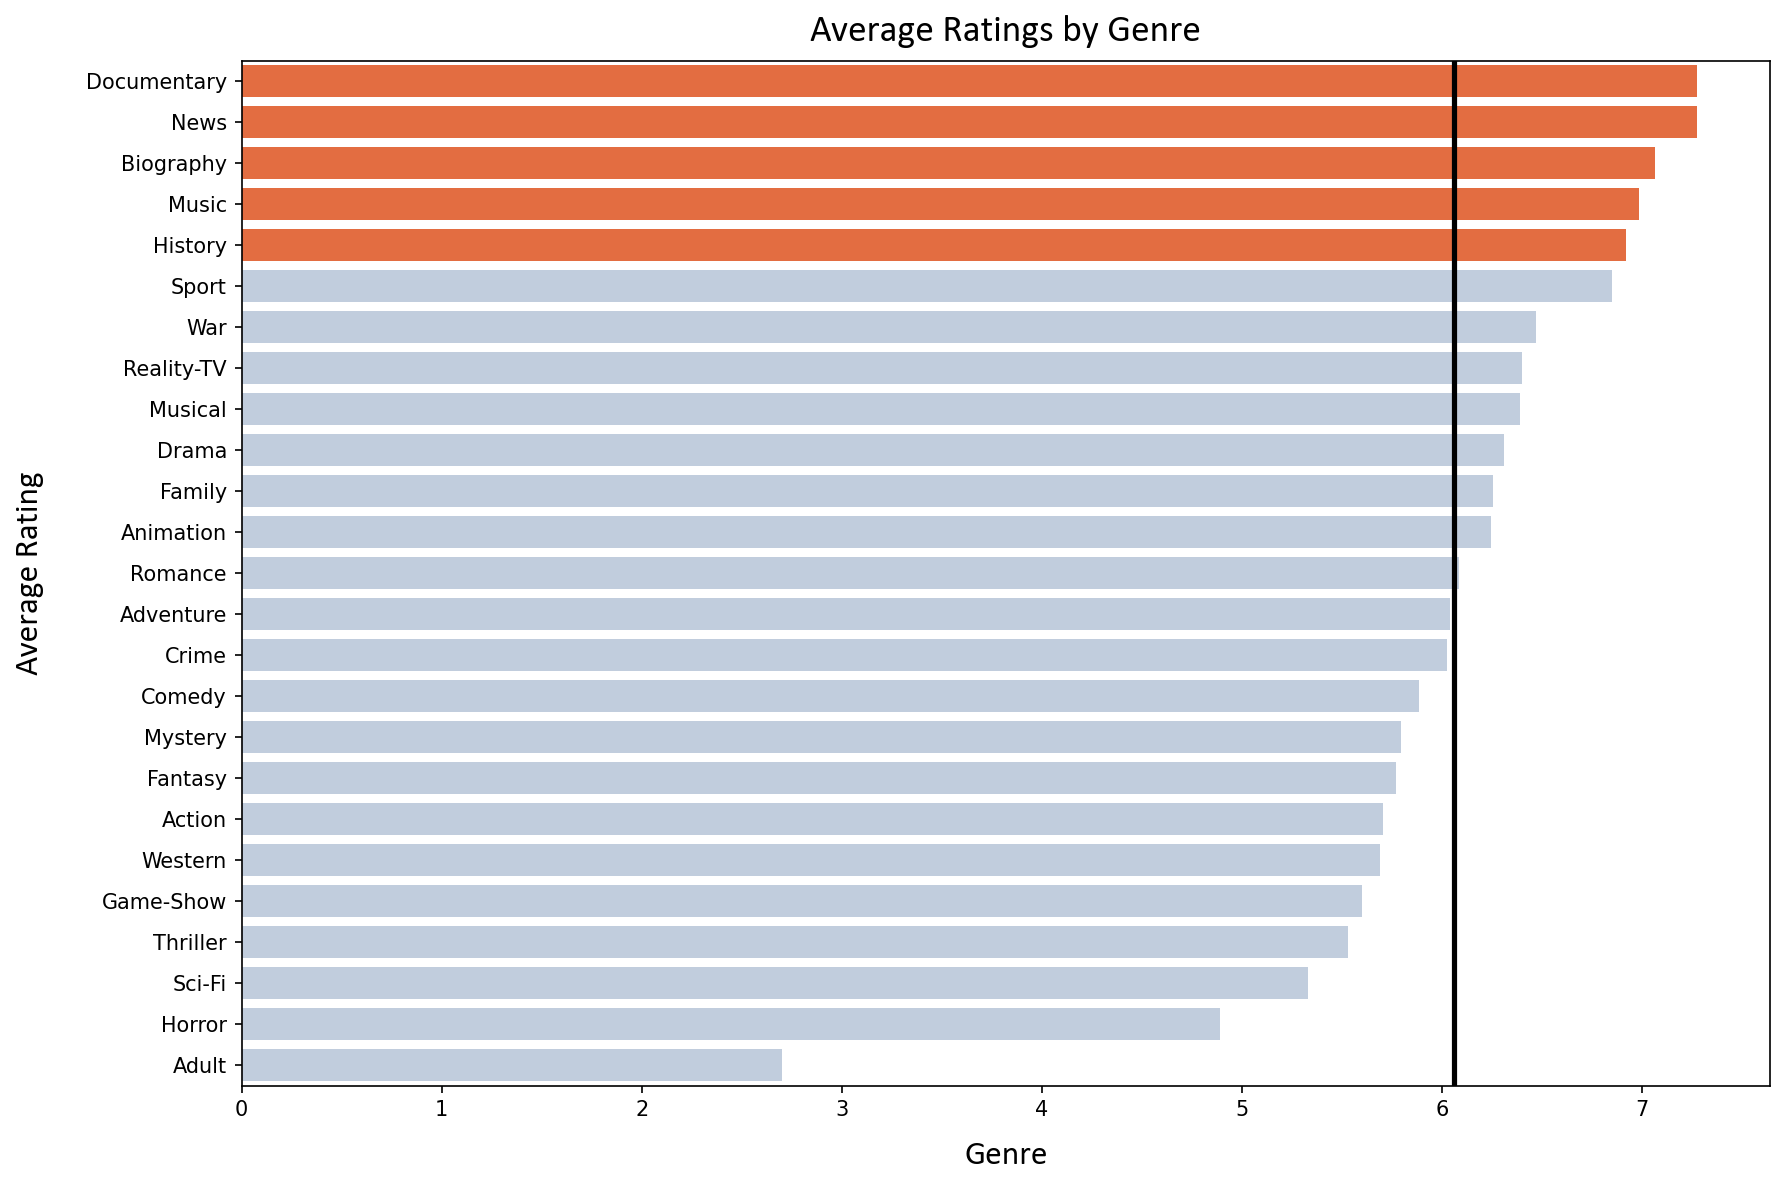

In [9]:
""" Visualizing the top 5 genres compared to all other genres """

title_font = {'fontname':'Calibri', 'size':'18', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} 
label_font = {'fontname':'Calibri', 'size':'16', 'weight':'normal'}

lowest_top_5_rating = grouped_genre_ratings['averagerating'][4]

average_rating = grouped_genre_ratings['averagerating'].mean()

median_rating = grouped_genre_ratings['averagerating'].median()


fig, ax = plt.subplots(figsize = (12, 8), dpi = 150)
cols = ['lightsteelblue' if x < lowest_top_5_rating else 'orangered' for x in grouped_genre_ratings['averagerating']]
sns.barplot(x = grouped_genre_ratings['averagerating'], y = grouped_genre_ratings['genres'], palette = cols, alpha = 0.85, ax = ax, orient ='h')
ax.set_title('Average Ratings by Genre', title_font)
ax.set_xlabel('Genre', label_font, labelpad = 10)
ax.set_ylabel('Average Rating', label_font, labelpad = 20)
ax.axvline(average_rating, c='k', ls='-', lw=2.5)
#ax.axvline(median_rating, c='orange', ls='--', lw=2.5)
plt.tight_layout()



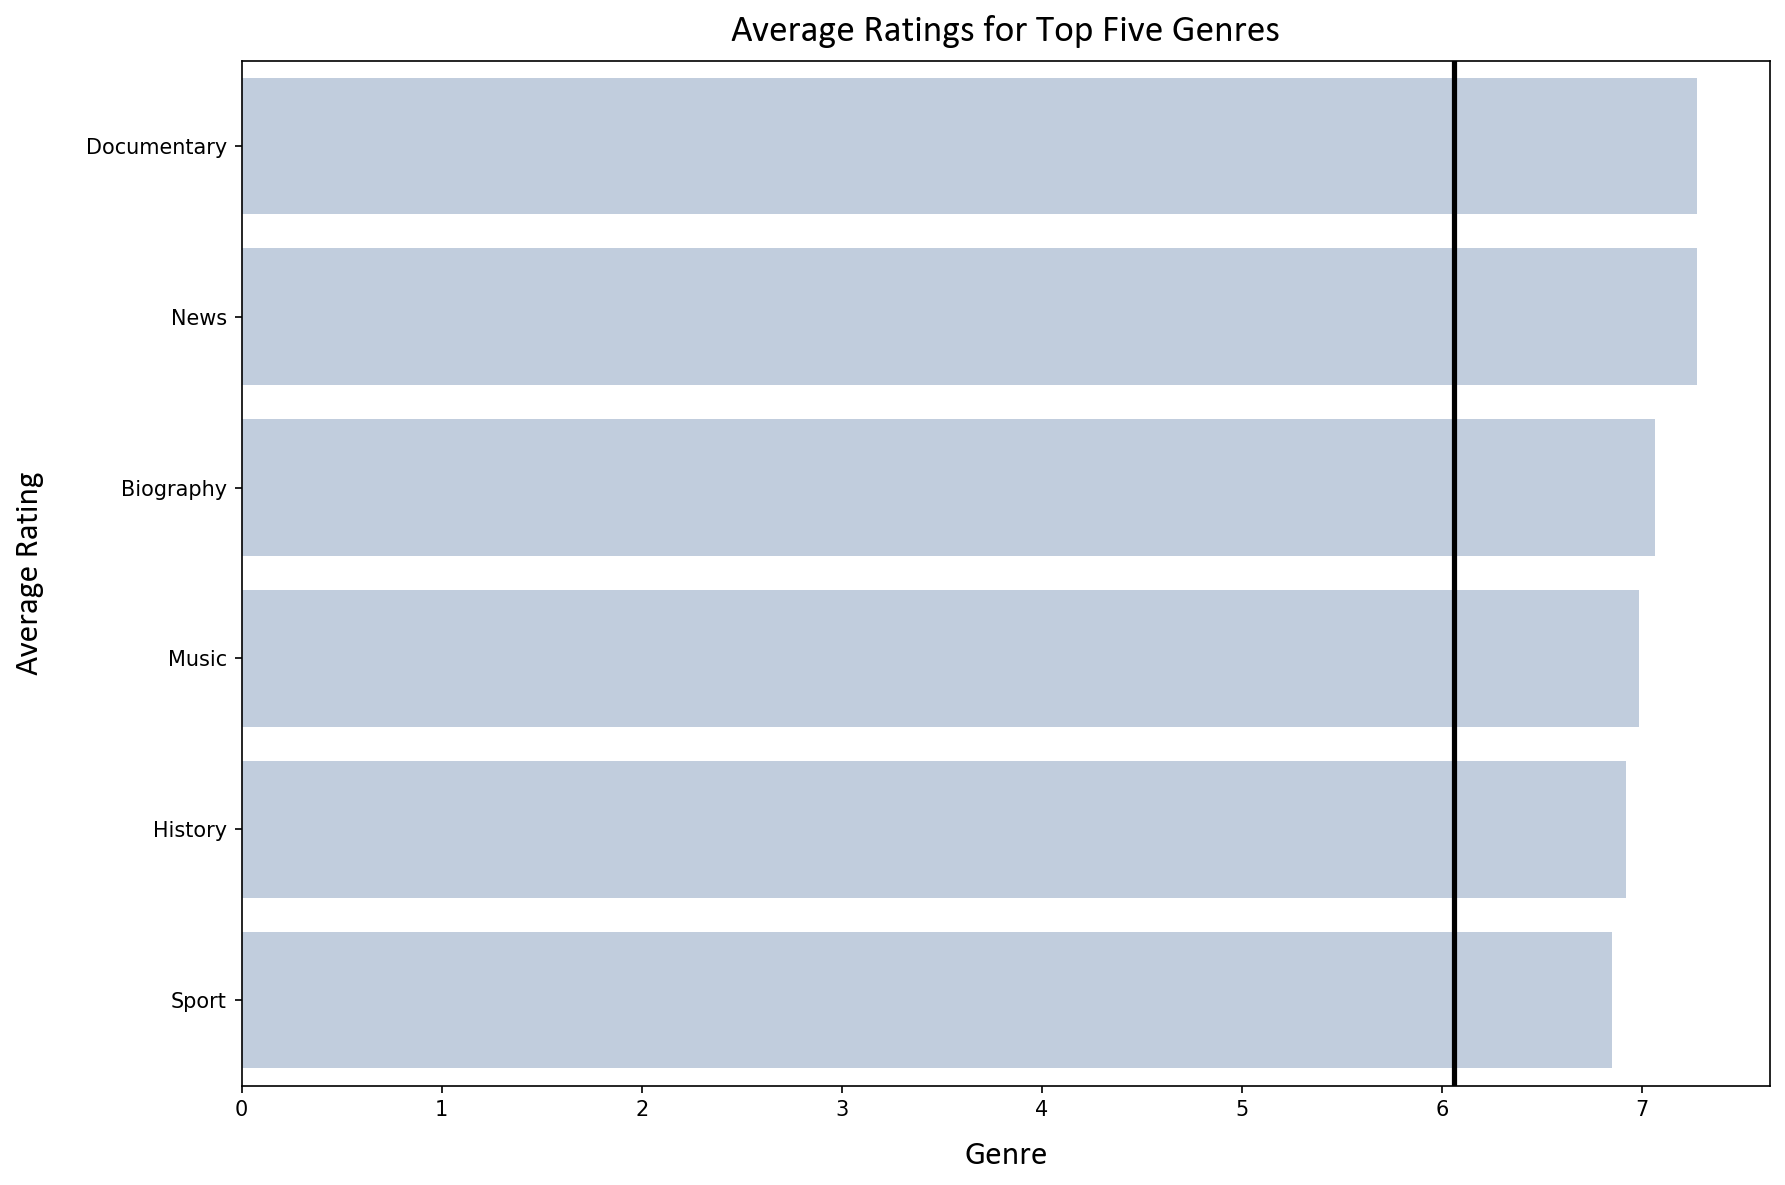

In [10]:
""" Visualizing top 5 genres against themselves """

top_5_genres = grouped_genre_ratings[0:6]

fig, ax = plt.subplots(figsize = (12, 8), dpi = 150)
cols = ['lightsteelblue']
sns.barplot(x = top_5_genres['averagerating'], y = top_5_genres['genres'], palette = cols, alpha = 0.85, ax = ax, orient ='h')
ax.set_title('Average Ratings for Top Five Genres', title_font)
ax.set_xlabel('Genre', label_font, labelpad = 10)
ax.set_ylabel('Average Rating', label_font, labelpad = 20)
ax.axvline(average_rating, c='k', ls='-', lw=2.5)
#ax.axvline(median_rating, c='orange', ls='--', lw=2.5)
plt.tight_layout()

After viewing the top genres we want to create a statistical analysis of our findings to display the consistancy or inconsitancy of these genres remaining in the top rankings

### Combining SQL Data to Profit Data

In [12]:
""" Combining the SQL database to the box office mojo and numbers dataset to establish profit based on genre """
tn_df = pd.read_csv('data/tn.movie_budgets.csv.gz')
tn_df.head()
tn_df['release_date'] = pd.to_datetime(tn_df['release_date'])
tn_df[tn_df.duplicated()]
tn_df.info()
tn_df['production_budget'] = tn_df['production_budget'].map(lambda x: int(x.strip('$').replace(',', '')))
tn_df['domestic_gross'] = tn_df['domestic_gross'].map(lambda x: int(x.strip('$').replace(',', '')))
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].map(lambda x: int(x.strip('$').replace(',', '')))
tn_df.describe().apply(lambda s: s.apply('{0:.5f}'.format))
tn_df['profitability'] = tn_df['worldwide_gross']/tn_df['production_budget']
tn_df.sort_values(by = 'profitability', ascending = False)[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 271.2+ KB


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profitability
5745,46,1972-06-30,Deep Throat,25000,45000000,45000000,1800.000000
5613,14,1980-03-21,Mad Max,200000,8750000,99750000,498.750000
5492,93,2009-09-25,Paranormal Activity,450000,107918810,194183034,431.517853
5679,80,2015-07-10,The Gallows,100000,22764410,41656474,416.564740
5406,7,1999-07-14,The Blair Witch Project,600000,140539099,248300000,413.833333
5709,10,2004-05-07,Super Size Me,65000,11529368,22233808,342.058585
5346,47,1942-08-13,Bambi,858000,102797000,268000000,312.354312
5773,74,1993-02-26,El Mariachi,7000,2040920,2041928,291.704000
5676,77,1968-10-01,Night of the Living Dead,114000,12087064,30087064,263.921614
5210,11,1976-11-21,Rocky,1000000,117235147,225000000,225.000000


In [13]:
tn_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profitability
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,6.532577
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2.546673
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,0.427892
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,4.243841
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,4.153696
...,...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0,0.000000
5778,79,1999-04-02,Following,6000,48482,240495,40.082500
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338,0.267600
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0,0.000000


In [14]:
""" Combining SQL data to money data """
cleaning_query = """
        SELECT *
        FROM movie_ratings mr
        JOIN movie_basics mb
            ON mr.movie_id = mb.movie_id
        WHERE mb.start_year <=2023 AND mr.numvotes >=14 AND mb.genres is not null AND mr.averagerating is not null
        ORDER BY mb.start_year DESC"""

cleaned_sqldata2 = pd.read_sql(cleaning_query, conn)
genres_and_budget = pd.merge(tn_df, cleaned_sqldata2, left_on='movie', right_on='primary_title')
#genres_and_budget
genres_and_budget =genres_and_budget[genres_and_budget['worldwide_gross'] != 0]
genres_and_budget['genres'] = genres_and_budget['genres'].astype(str)
genres_and_budget
# Splitting the genres 
genres_and_budget["genres"] = genres_and_budget["genres"].str.split(",")
genres_and_budget = genres_and_budget.apply(pd.Series.explode)
genres_and_budget
#grouped_genre_budget = grouped_genre_budget.sort_values(by='production_budget', ascending = False)
#grouped_genre_budget.reset_index(inplace = True)
#grouped_genre_budget.info()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profitability,movie_id,averagerating,numvotes,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,6.532577,tt1775309,6.1,43,tt1775309,Avatar,Abatâ,2011,93.0,Horror
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2.546673,tt1298650,6.6,447624,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,Action
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2.546673,tt1298650,6.6,447624,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,Adventure
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2.546673,tt1298650,6.6,447624,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,Fantasy
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,0.427892,tt6565702,6.0,24451,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,Action
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,49,2015-09-01,Exeter,25000,0,489792,19.591680,tt1945044,4.5,5156,tt1945044,Exeter,Exeter,2015,91.0,Mystery
2634,49,2015-09-01,Exeter,25000,0,489792,19.591680,tt1945044,4.5,5156,tt1945044,Exeter,Exeter,2015,91.0,Thriller
2635,49,2015-09-01,Exeter,25000,0,489792,19.591680,tt2782686,5.7,61,tt2782686,Exeter,Exeter,2014,NaN,Horror
2644,73,2012-01-13,Newlyweds,9000,4584,4584,0.509333,tt1880418,6.4,1436,tt1880418,Newlyweds,Newlyweds,2011,95.0,Comedy


In [22]:
""" Creating statistical tests """
# Ho: The top genre (documentary) has a production budget greater than or equal to 43 million (mean production budget)
# Ha: The top genre (documentary) has a production budget less than 43 million
# First need to group data by genre
grouped_genre_budget = (genres_and_budget.groupby(['genres']).mean())
grouped_genre_budget = grouped_genre_budget[['production_budget']]

sample_mean = genres_and_budget['production_budget'].mean()
documentary_budgets = genres_and_budget[genres_and_budget["genres"] == 'Documentary']["production_budget"]
t_statistic, p_value = stats.ttest_1samp(documentary_budgets, sample_mean)
print(documentary_budgets.mean())

print(sample_mean)
#alpha = 0.05  # Significance level

#print("T-statistic:", t_statistic)
#print("p-value:", (1-p_value/2))
# Acceot the Null Hypothesis
# The budget will be 

mean_doc_budget = genres_and_budget[genres_and_budget["genres"] == 'Documentary']['production_budget'].mean()
print('mean doc budget', mean_doc_budget)
standard_error = stats.sem(documentary_budgets)
margin_err = (standard_error * abs(t_statistic))/(math.sqrt(len(documentary_budgets)))
print(margin_err)
lower_bound = mean_doc_budget - margin_err
upper_bound = mean_doc_budget + margin_err
print(lower_bound, upper_bound)
print(t_statistic)
p_value = stats.norm.cdf((t_statistic))
print((1-(p_value)/2))
documentary_budgets.max()

21176008.640625
42175952.85665773
mean doc budget 21176008.640625
1856150.3699619945
19319858.270663004 23032159.010586996
-7.987294045696531
0.9999999999999997


175000000

In [24]:
genres_and_budget[genres_and_budget["genres"] == 'Documentary']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profitability,movie_id,averagerating,numvotes,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
85,98,2015-06-19,Inside Out,175000000,356461711,854235992,4.881349,tt2608638,7.5,60,tt2608638,Inside Out,Inside Out,2013,75.0,Documentary
147,92,2017-02-17,The Great Wall,150000000,45157105,334486852,2.229912,tt7535780,6.5,24,tt7535780,The Great Wall,The Great Wall,2017,72.0,Documentary
301,15,2001-12-28,Black Hawk Down,95000000,108638745,159691085,1.680959,tt4330758,7.8,167,tt4330758,Black Hawk Down,Black Hawk Down,2014,57.0,Documentary
304,18,2012-08-10,The Campaign,95000000,86907746,104907746,1.104292,tt2411684,6.9,14,tt2411684,The Campaign,The Campaign,2013,60.0,Documentary
307,19,2010-11-12,Unstoppable,95000000,81562942,165720921,1.744431,tt3070502,4.3,551,tt3070502,Unstoppable,Unstoppable,2013,65.0,Documentary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,10,2012-07-20,Burn,225000,1109276,1109276,4.930116,tt1781784,7.5,663,tt1781784,Burn,Burn,2012,86.0,Documentary
2586,45,2015-02-27,Butterfly Girl,180000,17503,17503,0.097239,tt2421956,8.6,43,tt2421956,Butterfly Girl,Butterfly Girl,2014,78.0,Documentary
2591,61,2015-08-21,Top Spin,150000,5858,5858,0.039053,tt4219836,6.9,513,tt4219836,Top Spin,Top Spin,2014,80.0,Documentary
2602,90,2014-06-19,The Past is a Grotesque Animal,100000,20056,20056,0.200560,tt3072636,7.2,118,tt3072636,The Past is a Grotesque Animal,The Past is a Grotesque Animal,2014,77.0,Documentary


In [23]:
# Ho: The top genre (documentary) has a production budget less than or equal to 4.48 (mean production budget)
# Ha: The top genre (documentary) has a production budget greater than 4.48
# First need to group data by genre

sample_mean = genres_and_budget['profitability'].mean()
documentary_profit = genres_and_budget[genres_and_budget["genres"] == 'Documentary']["profitability"]
t_statistic, p_value = stats.ttest_1samp(documentary_profit, sample_mean)

print('sample mean', sample_mean)
#alpha = 0.05  # Significance level


mean_doc_budget = genres_and_budget[genres_and_budget["genres"] == 'Documentary']['profitability'].mean()
standard_error = stats.sem(documentary_profit)
margin_err = (standard_error * abs(t_statistic))/(math.sqrt(len(documentary_profit)))
lower_bound = mean_doc_budget - margin_err
upper_bound = mean_doc_budget + margin_err
print(lower_bound, upper_bound)
p_value = stats.norm.cdf((t_statistic))
print(((p_value)/2))
#documentary_profit.max()

sample mean 4.481465485561303
5.1369199113434 5.264023450452852
0.3070370936527997


### Statistical Analysis

### The Numbers Statistical Analysis

In [19]:
tn_df.head()
# Combining SQL Data to this based on movie 



,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


<AxesSubplot:ylabel='production_budget'>

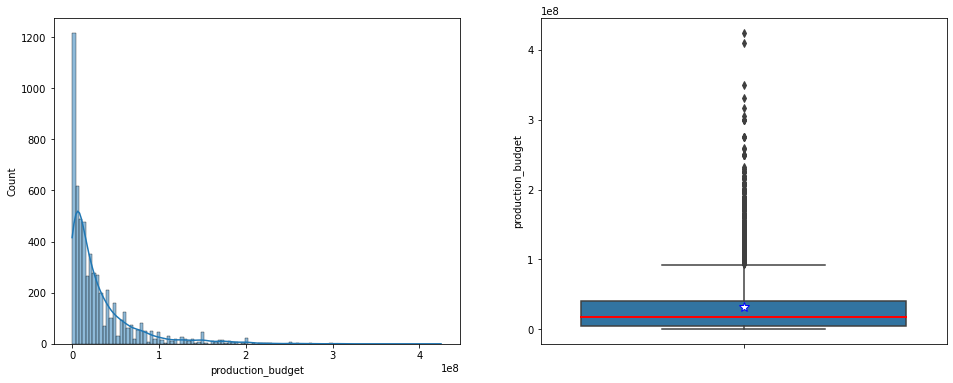

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.histplot(tn_df['production_budget'], kde = True, ax = ax1)
sns.boxplot(y = tn_df['production_budget'], showmeans = True, 
            meanprops={"marker":"*", "markerfacecolor":"white", "markeredgecolor":"blue", "markersize": "10"},
            medianprops={'color': 'red', 'linewidth': 2},  ax = ax2)

In [21]:
tn_df.sort_values(by = 'worldwide_gross', ascending = False)[:10]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
42,43,1997-12-19,Titanic,200000000,659363944,2208208395
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200
33,34,2015-06-12,Jurassic World,215000000,652270625,1648854864
66,67,2015-04-03,Furious 7,190000000,353007020,1518722794
26,27,2012-05-04,The Avengers,225000000,623279547,1517935897
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
41,42,2018-02-16,Black Panther,200000000,700059566,1348258224
260,61,2011-07-15,Harry Potter and the Deathly Hallows: Part II,125000000,381193157,1341693157


In [22]:
tn_df['year'] = tn_df['release_date'].dt.year
tn_df = tn_df[tn_df['year'] > 2000]

tn_df['month'] = tn_df['release_date'].dt.month
tn_df['day'] = tn_df['release_date'].dt.weekday
tn_df['profitability'] = tn_df['worldwide_gross']/tn_df['production_budget']
tn_df.sort_values(by = 'profitability', ascending = False)[:10]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,month,day,profitability
5492,93,2009-09-25,Paranormal Activity,450000,107918810,194183034,2009,9,4,431.517853
5679,80,2015-07-10,The Gallows,100000,22764410,41656474,2015,7,4,416.564740
5709,10,2004-05-07,Super Size Me,65000,11529368,22233808,2004,5,4,342.058585
5781,82,2005-08-05,My Date With Drew,1100,181041,181041,2005,8,4,164.582727
5656,57,2007-05-16,Once,150000,9445857,23323631,2007,5,2,155.490873
5774,75,2004-10-08,Primer,7000,424760,841926,2004,10,4,120.275143
5507,8,2004-06-11,Napoleon Dynamite,400000,44540956,46122713,2004,6,4,115.306782
5430,31,2004-08-06,Open Water,500000,30500882,55518641,2004,8,4,111.037282
5680,81,2006-09-29,Facing the Giants,100000,10178331,10243159,2006,9,4,102.431590
5211,12,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,1,4,101.759490


In [23]:
""" Establishing a null and alternative hypothesis based on genres and their ratings. """


' Establishing a null and alternative hypothesis based on genres and their ratings. '

In [24]:
pysqldf = lambda q: sqldf(q, globals())
conn = sqlite3.connect("data/im.db")
imdb_df = pd.read_sql("""SELECT * FROM movie_basics
                    JOIN movie_ratings ON movie_basics.movie_id = movie_ratings.movie_id
                    ORDER BY start_year DESC""", conn)
imdb_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43
1,tt0263814,On kadin,On kadin,2019,NaN,Drama,tt0263814,7.1,100
2,tt0285423,Abolição,Abolição,2019,NaN,Documentary,tt0285423,7.4,35
3,tt0437086,Alita: Battle Angel,Alita: Battle Angel,2019,122.0,"Action,Adventure,Sci-Fi",tt0437086,7.5,88207
4,tt0446792,Surviving in L.A.,Surviving in L.A.,2019,NaN,"Comedy,Drama,Romance",tt0446792,8.7,12
...,...,...,...,...,...,...,...,...,...
73851,tt8508676,Swansea Love Story,Swansea Love Story,2010,NaN,Documentary,tt8508676,7.3,7
73852,tt8750124,Hatchet Sisters,Hatchet Sisters,2010,75.0,Horror,tt8750124,5.4,5
73853,tt8919088,Peculiar Pets,Peculiar Pets,2010,NaN,Documentary,tt8919088,6.4,31
73854,tt9036874,The Mysterious Man by himself,The Mysterious Man by himself,2010,120.0,"Comedy,Romance",tt9036874,4.4,21


In [ ]:
""" Finding year range of movies """

# One of the movies is not even relevant because it starts in 2215? so get rid of that in data
query3 = """
        SELECT min(start_year) as oldest_movie, max(start_year) as newest_movie
        FROM movie_basics"""
year_range = pd.read_sql(query3, conn)
year_range

In [ ]:
""" Finding the Average Number of Votes per Movie """
query2 = """SELECT AVG(numvotes)
            FROM movie_ratings
            """
avg_num_ratings = pd.read_sql(query2, conn)
avg_num_ratings

In [5]:
""" Finding the Average Number of Votes per Movie """
query = """SELECT AVG(averagerating)
            FROM movie_ratings
            """
avg_rating = pd.read_sql(query, conn)
avg_rating

,AVG(averagerating)
0,6.332729


In [6]:
""" Finding out how many movies are in the database that have votes"""
query = """
        SELECT COUNT(movie_id) as num_movies
        FROM movie_basics
        """
num_movies = pd.read_sql(query, conn)
num_movies

,num_movies
0,146144


In [7]:
""" Finding the movies with the most ratings """
top_num_votes = """
        SELECT mr.numvotes, mb.primary_title, mb.original_title, mb.start_year, mr.averagerating
        FROM movie_ratings mr
        JOIN movie_basics mb
            ON mr.movie_id = mb.movie_id
        ORDER BY mr.numvotes desc"""
num_votes = pd.read_sql(top_num_votes, conn)
num_votes.head(10)

,numvotes,primary_title,original_title,start_year,averagerating
0,1841066,Inception,Inception,2010,8.8
1,1387769,The Dark Knight Rises,The Dark Knight Rises,2012,8.4
2,1299334,Interstellar,Interstellar,2014,8.6
3,1211405,Django Unchained,Django Unchained,2012,8.4
4,1183655,The Avengers,The Avengers,2012,8.1
5,1035358,The Wolf of Wall Street,The Wolf of Wall Street,2013,8.2
6,1005960,Shutter Island,Shutter Island,2010,8.1
7,948394,Guardians of the Galaxy,Guardians of the Galaxy,2014,8.1
8,820847,Deadpool,Deadpool,2016,8.0
9,795227,The Hunger Games,The Hunger Games,2012,7.2


In [8]:
# Based on the findings above the average number of votes a movie will receive is approximately 3523 
# There are currently 146144 unique movies in this database
# Since there are a large amount of movies we want to find movies that have a lot of ratings (at least average)
# However, more ratings means more people went to go see the movie meaning it is popular so we want to focus on those movies
# that are popular and have a good rating
# The average rating a movie receives is 6.3 so we want to also focus on those 

In [9]:
""" Create a table displaying information about movies
    and their respective ratings and number of ratings
"""
query1 = """
        SELECT *
        FROM movie_ratings mr
        JOIN movie_basics mb
            ON mr.movie_id = mb.movie_id
        WHERE mb.start_year <=2023 AND mr.numvotes >=14 AND mb.genres is not null AND mr.averagerating is not null
        ORDER BY mb.start_year DESC"""

info_ratings = pd.read_sql(query1, conn)
info_ratings['genres'] = info_ratings['genres'].astype(str)
info_ratings

,movie_id,averagerating,numvotes,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8.3,31,tt10356526,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance
1,tt10384606,8.9,559,tt10384606,Borderless,Borderless,2019,87.0,Documentary
2,tt1673732,8.0,20,tt1673732,Break Clause,Break Clause,2019,NaN,"Drama,Thriller"
3,tt10243678,6.5,1394,tt10243678,Chopsticks,Chopsticks,2019,100.0,"Comedy,Drama"
4,tt10254986,7.0,15,tt10254986,Q Ball,Q Ball,2019,96.0,Documentary
...,...,...,...,...,...,...,...,...,...
55515,tt2344840,6.6,37,tt2344840,H2-Oh!,Narm Pee Nong Sayong Kwan,2010,NaN,"Comedy,Horror"
55516,tt2349630,3.7,165,tt2349630,Whatever God Wants,Whatever God Wants,2010,100.0,"Comedy,Family"
55517,tt2365937,7.2,87,tt2365937,Re-encounter,"Hye-hwa, dong",2010,108.0,Drama
55518,tt2575400,7.1,15,tt2575400,"Cinémas d'Horreur - Apocalypse, Virus, Zombies","Cinémas d'Horreur - Apocalypse, Virus, Zombies",2010,55.0,Documentary


### Slicing SQL dataframe

In [10]:
""" Slicing the dataframe by genre """

#info_ratings.genres.split
info_ratings["genres"]= info_ratings["genres"].str.split(",")
info_ratings=info_ratings.apply(pd.Series.explode)
movie_df =info_ratings.groupby(['genres']).mean()
movie_df = movie_df[['averagerating']]
movie_df =movie_df.sort_values(by='averagerating', ascending = False)
movie_df = movie_df[0:6]

### Visualizing Data

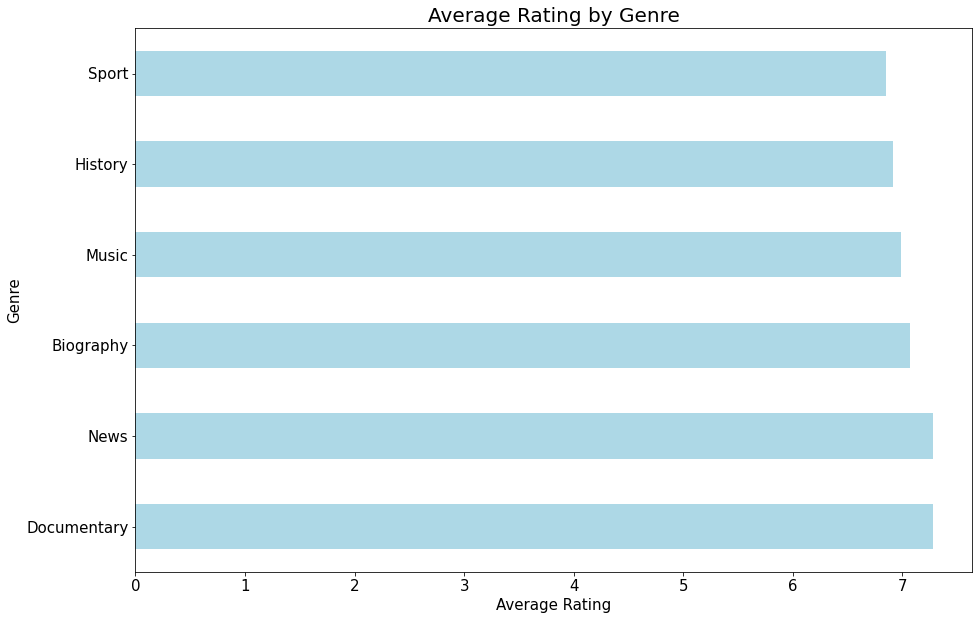

In [18]:
genre_bargraph = movie_df.plot(kind='barh', legend = False, figsize=(15,10), fontsize=15, color='lightblue')
genre_bargraph.set_title('Average Rating by Genre', fontsize=20)
genre_bargraph.set_xlabel('Average Rating', fontsize=15)
genre_bargraph.set_ylabel('Genre', fontsize=15);

Text(0, 0.5, 'Genre')

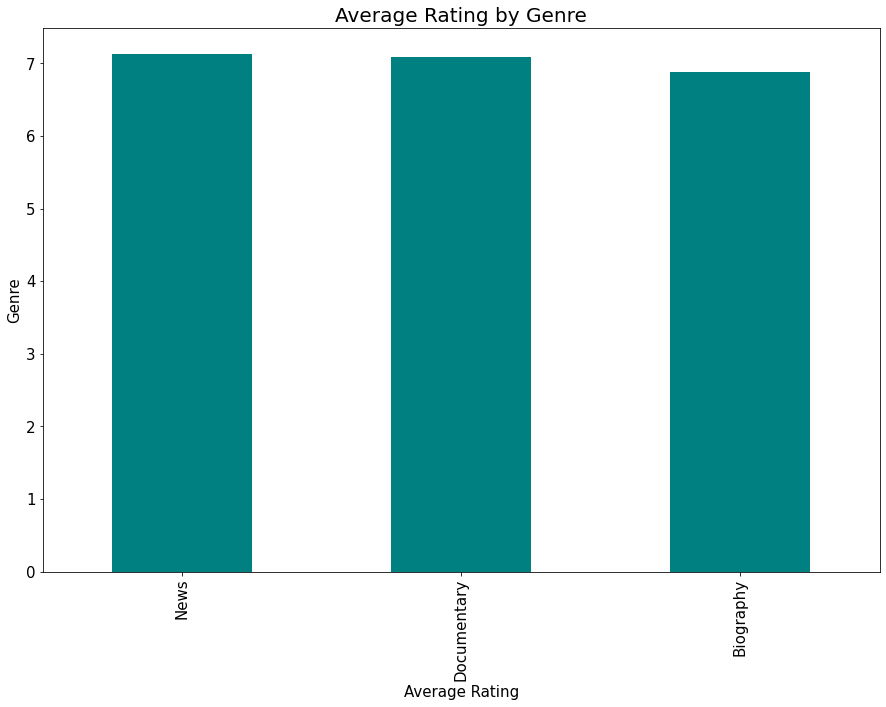

In [87]:
""" Top 3 Genres """
ranked_movies = movie_df.sort_values(by='averagerating', ascending=False)
top_genres = ranked_movies[0:3].plot(kind='bar', legend = False, figsize=(15,10), fontsize=15, color='teal')
top_genres.set_title('Average Rating by Genre', fontsize=20)
top_genres.set_xlabel('Average Rating', fontsize=15)
top_genres.set_ylabel('Genre', fontsize=15)

### List of Relevant Movies

In [80]:
pop_og_titles = list(info_ratings['original_title'])
pop_prim_titles = list(info_ratings['primary_title'])
# Checking all went into the list
print(len(pop_og_titles))

# Looking at Movie titles
print(pop_og_titles[0:10])

11621
['The Boy Who Harnessed the Wind', 'Justice League vs. the Fatal Five', 'Justice League vs. the Fatal Five', 'Justice League vs. the Fatal Five', 'Godzilla: King of the Monsters', 'Godzilla: King of the Monsters', 'Godzilla: King of the Monsters', 'The Kid Who Would Be King', 'The Kid Who Would Be King', 'The Kid Who Would Be King']


### Box Office Mojo

In [20]:
bom_gross = pd.read_csv('data/bom.movie_gross.csv.gz')
bom_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [24]:
""" Summary Statistics """
bom_gross.info()

# Missing Data
bom_gross.isna().any()

# Don't really need the studio name?

# Proportion of Missing Data
bom_gross.isna().sum()

# Missing a lot of information about money made in foreign market --> placeholder value using median or 0 could mean they
# didn;t make any mopney in the market?
print('Percentage of Null Foreign Gross Values:', len(bom_gross[bom_gross.foreign_gross.isna()])/ len(bom_gross))

# Checking for Duplicates
duplicates = bom_gross[bom_gross['title'].duplicated()]
print('Number of title duplicates '+ str(len(duplicates)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
Percentage of Null Foreign Gross Values: 0.3985828166519043
Number of title duplicates 1


In [85]:
bom_gross.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


In [56]:
""" Univariate Analysis"""

' Univariate Analysis'

### Rotten Tomatos Movie Information

In [23]:
rt_movie_info = pd.read_csv('data/rt.movie_info.tsv.gz', sep='\t')
rt_movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [24]:
""" Data Basic Information """
rt_movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


### Rotten Tomatos Movie Reviews

In [20]:
rt_reviews = pd.read_csv('data/rt.reviews.tsv.gz', sep='\t', encoding='cp1252')
rt_reviews.head(20)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
5,3,... Cronenberg's Cosmopolis expresses somethin...,NaN,fresh,Michelle Orange,0,Capital New York,"September 11, 2017"
6,3,"Quickly grows repetitive and tiresome, meander...",C,rotten,Eric D. Snider,0,EricDSnider.com,"July 17, 2013"
7,3,Cronenberg is not a director to be daunted by ...,2/5,rotten,Matt Kelemen,0,Las Vegas CityLife,"April 21, 2013"
8,3,"Cronenberg's cold, exacting precision and emot...",NaN,fresh,Sean Axmaker,0,Parallax View,"March 24, 2013"
9,3,Over and above its topical urgency or the bit ...,NaN,fresh,Kong Rithdee,0,Bangkok Post,"March 4, 2013"


#### Rotten Tomatos reviews questions & key points

In [ ]:
"""
These ratings are out of 5 so in order to compare to SQL database and other data files 
one of the rating scales needs to be adjusted 


"""

### TheMovie DB

In [27]:
movie_db = pd.read_csv('data/tmdb.movies.csv.gz', index_col = 0)
movie_db.head()


,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [29]:
""" Finding Average Rating and Average Number of Votes"""
avg_rating = np.average(movie_db['vote_average'])
print('Average Rating is ' + str(avg_rating))
avg_num_votes = np.average(movie_db['vote_count'])
print('Average Number of Votes is ' + str(avg_num_votes))

Average Rating is 5.991281064977184
Average Number of Votes is 194.22483689708488


#### TheMovie DB questions and key points

In [21]:
"""
What is populatiry out of and how is it measures?

"""

'\nWhat is populatiry out of and how is it measures?\n'

In [30]:
""" Data Basic Information """
movie_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


In [57]:
movie_db.describe()

,id,popularity,vote_average,vote_count
count,26517.000000,26517.000000,26517.000000,26517.000000
mean,295050.153260,3.130912,5.991281,194.224837
std,153661.615648,4.355229,1.852946,960.961095
min,27.000000,0.600000,0.000000,1.000000
25%,157851.000000,0.600000,5.000000,2.000000
50%,309581.000000,1.374000,6.000000,5.000000
75%,419542.000000,3.694000,7.000000,28.000000
max,608444.000000,80.773000,10.000000,22186.000000


### Movie Budgets

In [18]:
movie_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Movies that appear in all Data Sets

In [46]:
""" Finding the unique movies in the data sets provided by 
    listing unique values and creating one long set
    excluding the SQL database
"""
tmdb_unique = list(movie_db['title'].unique())
bom_gross_unique = list(bom_gross['title'].unique())
budgets_unique = list(movie_budgets['movie'].unique())
common_movies = []
for x in tmdb_unique:
    if x in bom_gross_unique:
        if x in budgets_unique:
            common_movies.append(x)
print(len(common_movies))

1170


### Combining Box Office and Numbers Data

In [30]:
""" Combining Data Set so we have more avalilable profit data """
frames = [movie_budgets, bom_gross]
money_df =pd.merge(bom_gross,movie_budgets, left_on=['title'], right_on=['movie'])
#money_df['Profit'].map(float(money_df['worldwide_gross'])-float(money_df['production_budget']))
money_df

KeyError: 'Profit'